In [2]:
#Packages
import warnings
warnings.filterwarnings('ignore')
import glob
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from itertools import cycle, islice
from sklearn.decomposition import PCA
from PIL import Image
from pymks import (plot_microstructures, PrimitiveTransformer, TwoPointCorrelation)

In [3]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [6]:
#Append images all to one list.
images = []
for filename in glob.glob(r'C:\Users\mikep\Desktop\project\data\evolution\two-point-figure\*.tif'):
    im=Image.open(filename)
    images.append(im)
np.shape(images[0])

(600, 600)

In [7]:
#List comprehension to convert the members of the "images" list to arrays.
imarrays = [np.array(x) for x in images]
imarrays[0].shape

(600, 600)

In [8]:
#Stacking all image arrays to create the 'sample' dimension and to convert the list to an array.
data_a = np.stack(imarrays, axis=0)
data_a.shape

(10, 600, 600)

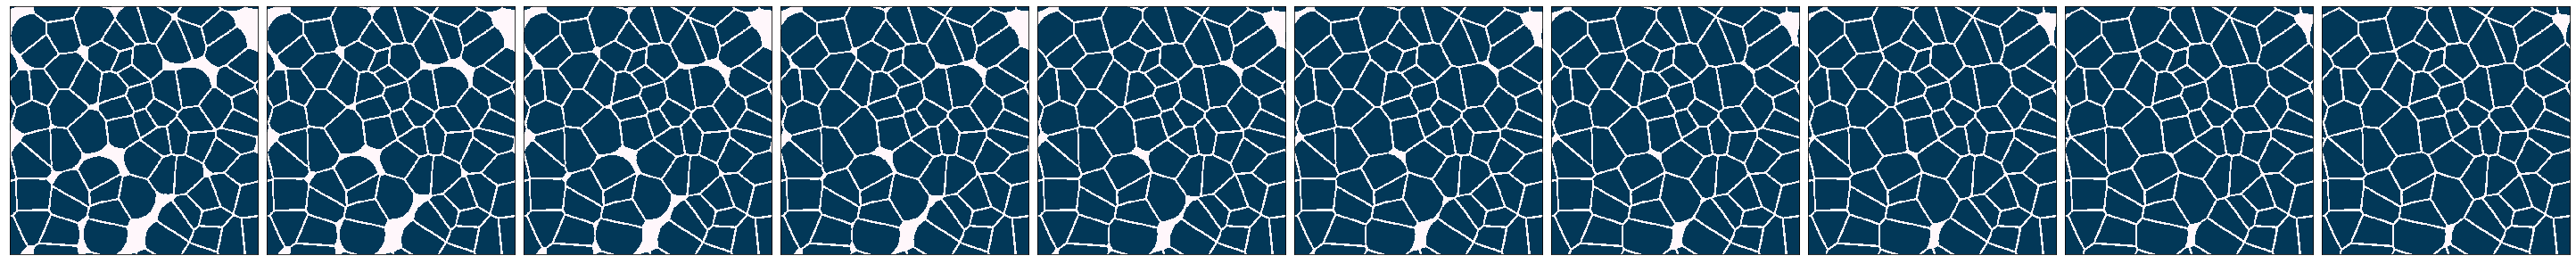

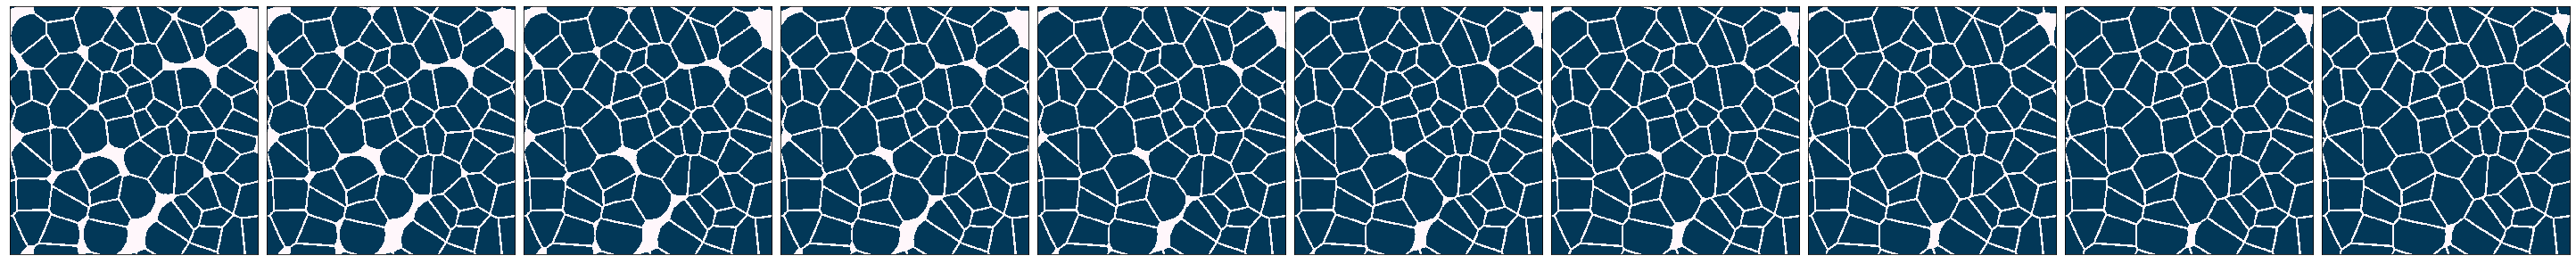

In [12]:
#Visualization of the microstructures.
plot_microstructures(*data_a[0:10], cmap='PuBu', colorbar=False)

In [13]:
#List comprehension to add the "phases" axis with the PrimitiveTransformer class.
data = PrimitiveTransformer(n_state=2, min_=0.0, max_=1.0).transform(data_a)
data.shape

(10, 600, 600, 2)

In [14]:
#Swaping the columns to solve the evolution issue.
data[:, :, :, [0, 1]]= data[:, :, :, [1, 0]]

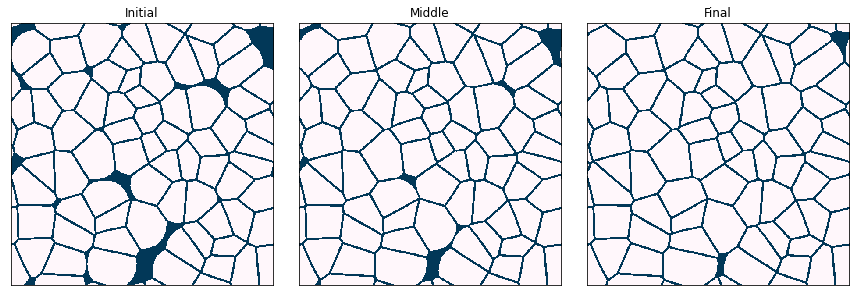

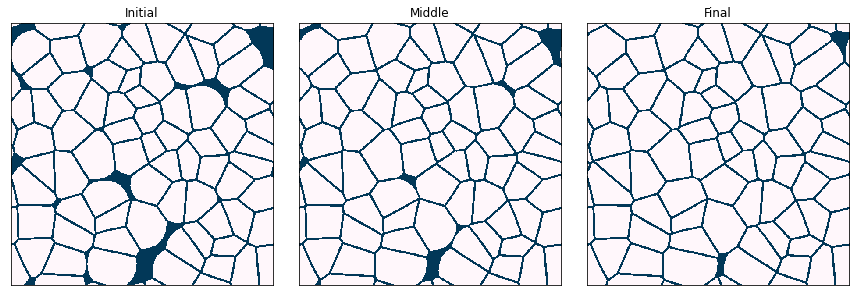

In [17]:
#Initial and middle microstructures.
plot_microstructures(data[2, :, :, 0], data[5, :, :, 0], data[9, :, :, 0], titles=['Initial', 'Middle', 'Final'], cmap='PuBu_r', colorbar=False)

In [38]:
#Calculating two-point statistics.
two_points = TwoPointCorrelation(periodic_boundary=True, cutoff=40, correlations=[(0, 0), (0, 1)]).transform(data)
initial_shape = two_points.shape
initial_shape

(10, 81, 81, 2)

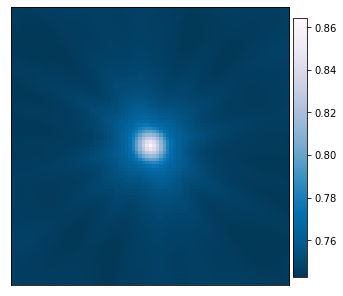

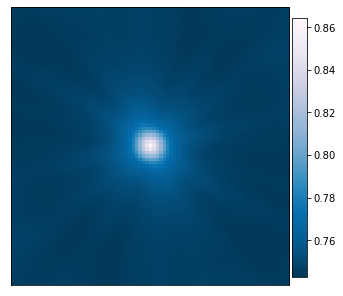

In [39]:
#Initial two-point statistics.
plot_microstructures(two_points[9, :, :, 0], cmap='PuBu_r', showticks=False)

In [ ]:
#Middle two-point statistics.
plot_microstructures(two_points[25, :, :, 0], titles=['Middle'], cmap='PuBu_r', showticks=False)

In [ ]:
#Final two-point statistics.
plot_microstructures(two_points[39, :, :, 0], titles=['Final'], cmap='PuBu_r', showticks=False)

In [ ]:
#Recrystallized Volume Fraction
print('Recrystallized Volume Fraction 10 = ', two_points[10, 130, 130, 0].compute())
print('Recrystallized Volume Fraction 25 = ', two_points[25, 130, 130, 0].compute())
print('Recrystallized Volume Fraction 39 = ', two_points[39, 130, 130, 0].compute())

In [ ]:
#list with recrystallized fraction
rex_fraction_list=[]
for i in range(40):
    rex_fraction_list.insert(i, two_points[i, 130, 130, 0].compute())

In [ ]:
df_rex=pd.DataFrame(rex_fraction_list)
df_rex.rename(columns={df_rex.columns[0]: "Two-Point Statistics" }, inplace = True)

In [ ]:
#normalize the data to account for grain boundaries
normalized_rex = (rex_fraction_list-min(rex_fraction_list))/(max(rex_fraction_list)-min(rex_fraction_list))
df_rex['Normalized'] = (normalized_rex)

micress = pd.read_csv(r'C:\Users\mikep\Desktop\thesis\figures\ReX-Fraction\ReX-figure.csv')
micress['Phase-Field']=micress['Phase-Field']*0.01
df_rex['Phase-Field']= micress['Phase-Field'].values

time_steps = pd.Series(np.arange(0,40))
df_rex.insert(loc=0, column='Time Steps', value=time_steps)
df_rex

In [ ]:
#csv file with rex fraction
df_rex.to_csv(r'C:\Users\mikep\Desktop\project\data\rex_fraction_evolution.csv')

In [ ]:
#plot rex fraction evolution (two points vs. normalized)
plt.rcParams.update({'font.size': 15})

my_colors = list(islice(cycle(['black', '#66c2a5']), None, len(df_rex)))
rex_fig = df_rex.plot(x ='Time Steps', y=['Two-Point Statistics', 'Normalized'],
                      figsize=(12, 10), color=my_colors, linewidth=3, marker='o', markersize=5)

plt.tick_params(axis="both", size=15, direction="in", pad=8)
plt.legend(frameon=False, bbox_to_anchor=(0.05, 0.95), loc='upper left', borderaxespad=0)

rex_fig.patch.set_edgecolor('black')
rex_fig.patch.set_linewidth('2')

rex_fig.set_xlabel("Time Step", fontsize=23, labelpad=15)
rex_fig.set_ylabel("Recrystallized Fraction", fontsize=23, labelpad=15)

plt.xlim([0.1, 39])
plt.ylim([0, 1])

rex_fig.figure.savefig(r'C:\Users\mikep\Desktop\thesis\figures\ReX-Fraction\two_points-normalized.png', facecolor='w', dpi=600)

In [ ]:
#plot rex fraction evolution (normalized vs. phase-field)
plt.rcParams.update({'font.size': 15})

my_colors = list(islice(cycle(['black', '#fc8d62']), None, len(df_rex)))
rex_fig = df_rex.plot(x ='Time Steps', y=['Normalized', 'Phase-Field'],
                      figsize=(12, 10), color=my_colors, linewidth=3, marker='o', markersize=5)

plt.tick_params(axis="both", size=15, direction="in", pad=8)
plt.legend(frameon=False, bbox_to_anchor=(0.05, 0.95), loc='upper left', borderaxespad=0)

rex_fig.patch.set_edgecolor('black')
rex_fig.patch.set_linewidth('2')

rex_fig.set_xlabel("Time Step", fontsize=23, labelpad=15)
rex_fig.set_ylabel("Recrystallized Fraction", fontsize=23, labelpad=15)

plt.xlim([0.1, 39])
plt.ylim([0, 1])

rex_fig.figure.savefig(r'C:\Users\mikep\Desktop\thesis\figures\ReX-Fraction\normalized-phase_field.png', facecolor='w', dpi=600)

In [ ]:
#Reshape the two-point statistics for the PCA model.
reshaped_two_points=two_points.reshape(40, -1)
reshaped_two_points.shape

In [ ]:
#PCA
pca = PCA(svd_solver='full', n_components=3)
pc_scores=pca.fit_transform(reshaped_two_points)
pc_scores.shape

In [ ]:
print(pca.components_) 
print(pca.components_.shape)

In [ ]:
#First principal component (PC1). 
pc1, pc2, pc3 = np.split(pc_scores, 3, axis=1)
print(pc1.shape)
print(pc1)
##Note: No "axis=1" in order to obtain pc-scores for different microstructure classes.

In [ ]:
zeros=np.zeros((40, 2))
reshaped_pc1=np.hstack((pc1,zeros))
print(reshaped_pc1)
print(reshaped_pc1.shape)
print(reshaped_pc1[26])

In [ ]:
#Explained variance by each principal component.
exp_var_pca=pca.explained_variance_ratio_*100
cum_sum=np.cumsum(pca.explained_variance_ratio_)*100
cum_sum_2d = [ '%.2f' % elem for elem in cum_sum ]
cum_sum_2d = np.array(cum_sum_2d)

print(exp_var_pca)

In [ ]:
#plot explained variance

fig = plt.figure(1, figsize=(12, 10))

x1 = range(1, len(exp_var_pca)+1)
y1 = exp_var_pca
x2 = range(1, len(cum_sum)+1)
y2 = cum_sum

plt.bar(x1, y1, color='#999999', edgecolor='black', linewidth='1', alpha=0.9, width = 0.5, align='center', label='Individual explained variance')

plt.plot(x2, y2, label='Cumulative explained variance', c='black', linewidth=3)
plt.scatter(x2, y2, s=80, facecolors='black', edgecolors='black')

for i, txt in enumerate(cum_sum_2d):
    plt.annotate(txt, (x2[i], y2[i]), size=15, xytext=(x2[i], y2[i]+3))
    
plt.xlabel('Principal Component Index', fontsize=23, labelpad=15)
plt.ylabel('Explained Variance Ratio', fontsize=23, labelpad=15)

plt.xticks(np.arange(1, 4, step=1), fontsize=20)
plt.yticks(fontsize=20)

plt.legend(frameon=False, loc='best')
plt.ylim([0, 108])

#fig.savefig(r'C:\Users\mikep\Desktop\thesis\figures\explained_variance.png', dpi=600)
plt.show()

In [ ]:
#Principal component analysis visualization.

fig = plt.figure(figsize=(15, 12))
ax = fig.add_subplot(111)

plt.scatter(pc_scores[:,0], pc_scores[:,1], c='black', marker='o', s=10) # markeredgecolor='black') 
plt.plot(pc_scores[:,0], pc_scores[:,1], c='skyblue', ls='--')

ax.set_xlabel("First Principal Component (PC1)",  fontsize=22, labelpad=20)
ax.set_ylabel("Second Principal Component (PC2)",  fontsize=22, labelpad=20)

ax.tick_params(axis="both", size=15, direction="in", pad=8)

#ax.set_title('Time Evolution of PC-scores', fontsize=30, pad=20)

ax.grid(which='major', axis='both', linestyle = '--', linewidth = 0.5)

ax.patch.set_edgecolor('black')
ax.patch.set_linewidth('2') 

n = range(0,40)
for i, txt in enumerate(n):
    plt.annotate(txt, (pc_scores[i,0], pc_scores[i,1]), xytext=(pc_scores[i,0]+1, pc_scores[i,1]+0.9), size=10)

fig.savefig(r'C:\Users\mikep\Desktop\thesis\figures\pc-evolution.png', facecolor='w', dpi=600)
fig.show()

In [ ]:
#Inverting and reshaping the data.

two_points_inv_pc = pca.inverse_transform(pc_scores)
two_points_inv_pc1 = pca.inverse_transform(reshaped_pc1)

recovered_two_points_pc = np.reshape(two_points_inv_pc, initial_shape)
recovered_two_points_pc1 = np.reshape(two_points_inv_pc1, initial_shape)

print(two_points_inv_pc.shape)
print(recovered_two_points_pc.shape)
print(recovered_two_points_pc)

In [ ]:
#Recovered two-point statistics using both PC scores. 
plot_microstructures(recovered_two_points_pc[25, :, :, 0], titles=['Middle'], cmap='PuBu_r', showticks=False)

In [ ]:
#Recovered first two-point statistics using only PC1. recovered_two_points_pc1[0, :, :, 0], 
plot_microstructures(recovered_two_points_pc1[25, :, :, 0], titles=['Middle'], cmap='PuBu_r', showticks=False)

In [ ]:
#Save the pc scores.
df1 = pd.DataFrame(pc1)
df1.to_csv(r'C:\Users\mikep\Desktop\project\data\pc_scores\pc1_evolution.csv')

In [ ]:
zeros2=np.zeros((40, 3))
zeros2[(0,0)]=55.14937987
print(zeros2)

In [ ]:
two_points_inv_pcnew = pca.inverse_transform(zeros2)
print(two_points_inv_pcnew.shape)

In [ ]:
recovered_two_points = np.reshape(two_points_inv_pcnew, initial_shape)
print(recovered_two_points.shape)

In [ ]:
plot_microstructures(recovered_two_points[25, :, :, 0], titles=['projected'], cmap='PuBu_r', showticks=False)